In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mp
import sklearn
from IPython.display import Image, HTML
import statsmodels.api as sm
from sklearn import model_selection
from sklearn import metrics

import laUtilities as ut

%matplotlib inline

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.regression.linear_model import OLS
import statsmodels.formula.api as smf

np.random.seed(9876789)

# Regularization

Today, we'll look at some additional aspects of Linear Regression.

Our first topic is multicollinearity.

## Multicollinearity

To illustrate the multcollinearity problem, we'll load a standard dataset.

The Longley dataset contains various US macroeconomic variables from 1947–1962.

```{note}
A good reference for the following is 
https://www.sjsu.edu/faculty/guangliang.chen/Math261a/Ch9slides-multicollinearity.pdf
and
https://www.stat.cmu.edu/~ryantibs/datamining/lectures/17-modr2.pdf
```

In [2]:
from statsmodels.datasets.longley import load_pandas
y = load_pandas().endog
X = load_pandas().exog
X['const'] = 1.0
X.index = X['YEAR']
y.index = X['YEAR']
X.drop('YEAR', axis = 1, inplace = True)
X

,GNPDEFL,GNP,UNEMP,ARMED,POP,const
YEAR,,,,,,
1947.0,83.0,234289.0,2356.0,1590.0,107608.0,1.0
1948.0,88.5,259426.0,2325.0,1456.0,108632.0,1.0
1949.0,88.2,258054.0,3682.0,1616.0,109773.0,1.0
1950.0,89.5,284599.0,3351.0,1650.0,110929.0,1.0
1951.0,96.2,328975.0,2099.0,3099.0,112075.0,1.0
1952.0,98.1,346999.0,1932.0,3594.0,113270.0,1.0
1953.0,99.0,365385.0,1870.0,3547.0,115094.0,1.0
1954.0,100.0,363112.0,3578.0,3350.0,116219.0,1.0
1955.0,101.2,397469.0,2904.0,3048.0,117388.0,1.0


In [3]:
ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     156.4
Date:                Wed, 03 Nov 2021   Prob (F-statistic):           3.70e-09
Time:                        11:31:57   Log-Likelihood:                -117.83
No. Observations:                  16   AIC:                             247.7
Df Residuals:                      10   BIC:                             252.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GNPDEFL      -48.4628    132.248     -0.366      0.7

/Users/crovella/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


What does this mean?

>In statistics, multicollinearity (also collinearity) is a phenomenon in which two or more predictor variables in a multiple regression model are highly correlated, meaning that one can be linearly predicted from the others with a substantial degree of accuracy.

(Wikipedia)

### Condition Number

The condition number being referred to is the condition number of the design matrix.

That is the $X$ in $X\beta = y$. 

Remember that to solve a least-squares problem $X\beta = y$, we solve the normal equations

$$X^TX\beta = X^Ty.$$

These equations always have at least one solution.

However, the "at least one" part is problematic!

If there are multiple solutions, they are in a sense all equivalent in that they yield the same value of $\Vert X\beta - y\Vert$.

However, the actual values of $\beta$ can vary tremendously and so it is not clear how best to interpret the case when $X$ does not have full column rank.

When does this problem occur?   Look at the normal equations:

$$X^TX\beta = X^Ty.$$

It occurs when $X^TX$ is __not invertible.__

In that case, we cannot simply solve the normal equations by computing $\hat{\beta} = (X^TX)^{-1}X^Ty.$

When is $(X^TX)$ not invertible?

This happens when the columns of $X$ are linearly dependent --

That is, one column can be expressed as a linear combination of the other columns.

This is the simplest kind of __multicollinearity__.

### Sources of Multicollinearity

One obvious case is if $X$ has more columns than rows.   That is, if data have __more features than there are observations__.

This case is easy to recognize. 

However, a more insidious case occurs when the columns of $X$ happen to be linearly dependent because of the nature of the data itself.

This happens when one column is a linear function of the other columns.   

In other words, one independent variable is a linear function of one or more of the others.

Unfortunately, in practice we will run into trouble even if variables are __almost__ linearly dependent. 

Near-dependence causes problems because measurements are not exact, and small errors are magnified when computing $(X^TX)^{-1}$. 

So, more simply, when two or more columns are __strongly correlated__, we will have problems with linear regression.

Consider an experiment with the following predictors:
    
$$ x_1 = \text{arm length} $$

$$ x_2 = \text{leg length} $$

$$ x_3 = \text{height} $$

$$ \dots $$

Condition number is a measure of whether $X$ is __nearly__ lacking full column rank.

In other words, whether some column is __close to__ being a linear combination of the other columns.

In this case, the actual values of $\beta$ can vary a lot due to noise in the measurements.

One way to say that $X^TX$ is not invertible is to say that it has at least one zero eigenvalue.   

Condition number relaxes this -- it asks if $X^TX$ has a __very small__ eigenvalue (compared to its largest eigenvalue).

An easy way to assess this is using the SVD of $X$.

(Thank you, "swiss army knife"!)

The eigenvalues of $X^TX$ are the squares of the singular values of $X$.   

So the condition number of $X$ is defined as:

$$\kappa(X) = \frac{\sigma_{\mbox{max}}}{\sigma_{\mbox{min}}}$$

where $\sigma_{\mbox{max}}$ and $\sigma_{\mbox{min}}$ are the largest and smallest singular values of $X$.

A large condition number is evidence of a problem.   

* If the condition number is less than 100, there is no serious problem
with multicollinearity.
* Condition numbers between 100 and 1000 imply moderate to strong multicollinearity.
* Condition numbers bigger than 1000 indicate severe multicollinearity.

Recall that the condition number of our data is around $10^8$. 

Let's look at pairwise scatterplots of the Longley data:

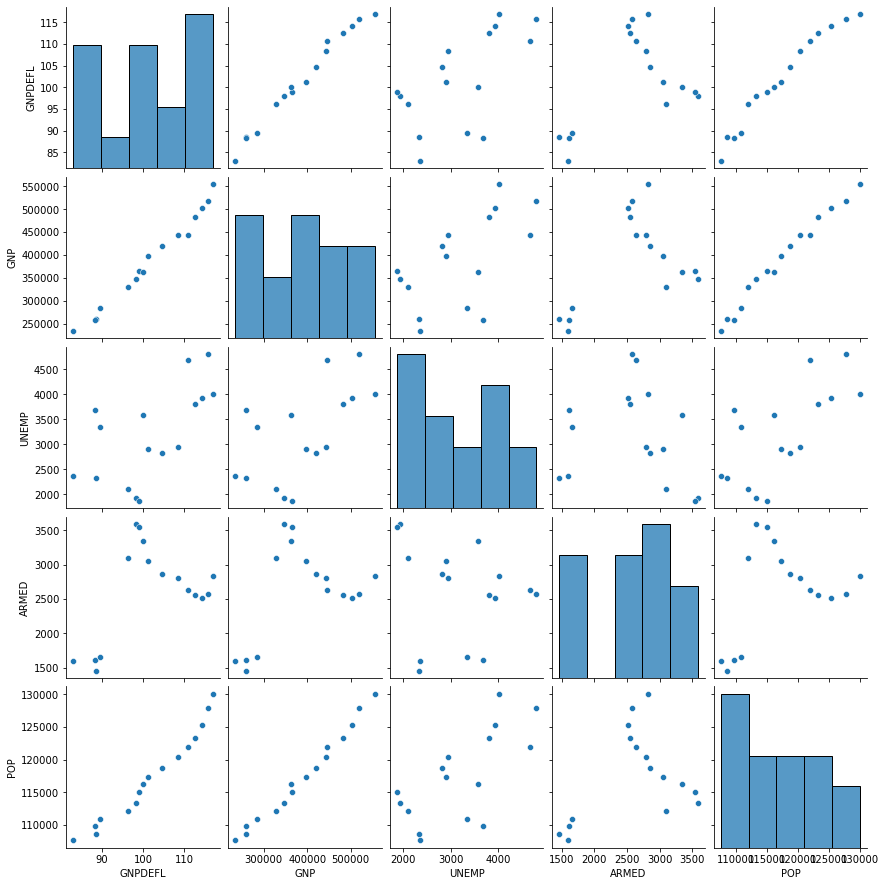

In [4]:
sns.pairplot(X[['GNPDEFL', 'GNP', 'UNEMP', 'ARMED', 'POP']]);

We can see __very__ strong linear relationships between, eg, __GNP Deflator__, __GNP__, and __Population.__

## Addressing Multicollinearity


There are some things that can be done if it does happen.

We will review two strategies:

1. Ridge Regression
2. Model Selection via LASSO

### Ridge Regression

The first thing to note is that when columns of $X$ are nearly dependent, the components of $\hat{\beta}$ tend to be __large in magnitude__.

Consider a regression in which we are predicting the point $\mathbf{y}$ as a linear function of two $X$ columns, which we'll denote $\mathbf{u}$ and $\mathbf{v}$.

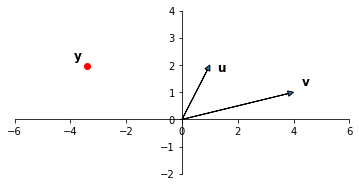

In [5]:
ax = ut.plotSetup(size=(6,3))
ut.centerAxes(ax)
u = np.array([1, 2])
v = np.array([4, 1])
alph = 1.6
beta = -1.25
sum_uv = (alph * u) + (beta * v)
ax.arrow(0, 0, u[0], u[1], head_width=0.2, head_length=0.2, length_includes_head = True)
ax.arrow(0, 0, v[0], v[1], head_width=0.2, head_length=0.2, length_includes_head = True)
ax.text(sum_uv[0]-.5, sum_uv[1]+0.25, r'$\mathbf{y}$',size=12)
ax.text(u[0]+0.25, u[1]-0.25, r'${\bf u}$', size=12)
ax.text(v[0]+0.25, v[1]+0.25, r'${\bf v}$',size=12)
ut.plotPoint(ax, sum_uv[0], sum_uv[1])
ax.plot(0, 0, '');

Via least-squares, we determine the coefficients $\beta_1$ and $\beta_2$:

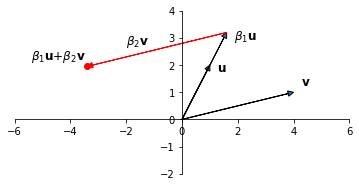

In [6]:
ax = ut.plotSetup(size=(6,3))
ut.centerAxes(ax)
u = np.array([1, 2])
v = np.array([4, 1])
alph = 1.6
beta = -1.25
sum_uv = (alph * u) + (beta * v)
ax.arrow(0, 0, u[0], u[1], head_width=0.2, head_length=0.2, length_includes_head = True)
ax.arrow(0, 0, v[0], v[1], head_width=0.2, head_length=0.2, length_includes_head = True)
ax.arrow(0, 0, alph * u[0], alph * u[1], head_width=0.2, 
         head_length=0.2, length_includes_head = True)
ax.arrow(alph * u[0], alph * u[1], sum_uv[0] - alph * u[0], sum_uv[1] - alph * u[1], 
         head_width=0.2, 
         head_length=0.2, length_includes_head = True, color = 'r')
ax.text(sum_uv[0]-2, sum_uv[1]+0.25, r'$\beta_1{\bf u}$+$\beta_2{\bf v}$',size=12)
ax.text(u[0]+0.25, u[1]-0.25, r'${\bf u}$', size=12)
ax.text(alph * u[0]+0.25, alph * u[1]-0.25, r'$\beta_1{\bf u}$', size=12)
ax.text(-2, 2.75, r'$\beta_2{\bf v}$', size=12)
ax.text(v[0]+0.25, v[1]+0.25, r'${\bf v}$',size=12)
ut.plotPoint(ax, sum_uv[0], sum_uv[1])
ax.plot(0, 0, '');

Now consider if the columns of $X$ are __nearly dependent__: ie, they are almost in the same direction:

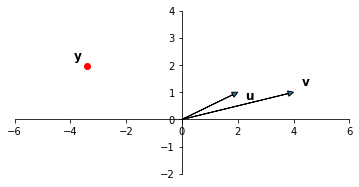

In [7]:
ax = ut.plotSetup(size=(6,3))
ut.centerAxes(ax)
u = np.array([2, 1])
v = np.array([4, 1])
ax.arrow(0, 0, u[0], u[1], head_width=0.2, head_length=0.2, length_includes_head = True)
ax.arrow(0, 0, v[0], v[1], head_width=0.2, head_length=0.2, length_includes_head = True)
ax.text(sum_uv[0]-.5, sum_uv[1]+0.25, r'$\mathbf{y}$',size=12)
ax.text(u[0]+0.25, u[1]-0.25, r'${\bf u}$', size=12)
ax.text(v[0]+0.25, v[1]+0.25, r'${\bf v}$',size=12)
ut.plotPoint(ax, sum_uv[0], sum_uv[1])
ax.plot(0, 0, '');

If you imagine the values of $\beta_1$ and $\beta_2$ necessary to create $\mathbf{y} = \beta_1{\bf u}$+$\beta_2{\bf v}$, you can see that $\beta_1$ and $\beta_2$ will be __very large__ in magnitude.

This geometric argument illustrates why the regression coefficients will be very large under multicollinearity.

Put another way, the value of $\Vert\beta\Vert$ will be very large.

### Ridge Regression

Ridge regression adjusts least squares regression by shrinking the estimated coefficients towards zero.

The purpose is to fix the magnitude inflation of $\Vert\beta\Vert$.

To do this, Ridge regression assumes that the model has no intercept term --

both the response and the predictors have been centered so that $\beta_0 = 0$.

Ridge regression then consists of adding a penalty term to the regression:

$$ \hat{\beta} = \arg \min_\beta \Vert X\beta - y \Vert^2 + \lambda \Vert\beta\Vert^2.$$

For any given $\lambda$ this has a closed-form solution in which $\hat{\beta}$ is a linear function of $X$ (just as in ordinary least squares).

The solution to the Ridge regression problem always exists and is unique, even when the data contains multicollinearity.


Here, $\lambda \geq 0$ is a tradeoff parameter (amount of shrinkage).

It controls the strength of the penalty term:
* When $\lambda = 0$, we get the least squares estimator: $\hat{\beta} = (X^TX)^{−1}X^T\mathbf{y}$
* When $\lambda = \infty$, we get $\hat{\beta} = 0.$
* Increasing the value of $\lambda$ forces the norm of $\hat{\beta}$ to decrease, yielding smaller coefficient estimates (in magnitude).

For a finite, positive value of $\lambda$, we are balancing two tasks: fitting
a linear model and shrinking the coefficients.

So once again, we have a __hyperparameter__ that controls model complexity:
* hence, we typically set $\lambda$ by holding out data, ie, __cross-validation.__

Note that the penalty term $\Vert\beta\Vert^2$ would be unfair to the different predictors, if they are not on the same scale. 

Therefore, if we know that the variables are not measured in the same units, we typically first perform unit normal scaling on the columns of $X$ and on $\mathbf{y}$ (to standardize the predictors), and then perform ridge regression.

Note that by scaling $\mathbf{y}$ to zero-mean, we do not need (or include) an intercept in the model.

The general strategy of including extra criteria to improve the behavior of a model is called "regularization."

Accordingly, Ridge regression is also known as __Tikhanov regularization__.

Here is the performance of Ridge regression on the Longley data.

We are training on half of the data, and using the other half for testing.

In [8]:
from sklearn.metrics import r2_score
nreps = 1000

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X[['GNPDEFL', 'GNP', 'UNEMP', 'ARMED', 'POP']])
y_std = scaler.fit_transform(y.values.reshape(-1, 1))

np.random.seed(1)

vals = []
for alpha in np.r_[np.array([0]), 10**np.linspace(-8.5, -0.5, 20)]:
    res = []
    for rep in range(nreps):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X_std, y_std,
            test_size=0.5)
        model = sm.OLS(y_train, X_train)
        results = model.fit_regularized(alpha = alpha, L1_wt = 0)
        y_oos_predict = results.predict(X_test)
        r2_test = r2_score(y_test, y_oos_predict)
        res.append(r2_test)
    vals.append([alpha, np.mean(res), np.std(res)/np.sqrt(nreps)])

results = np.array(vals)

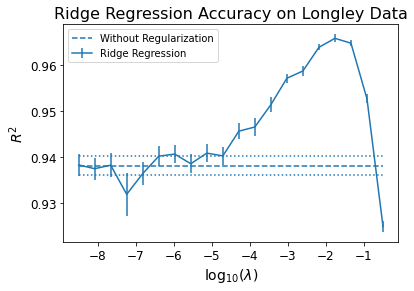

In [9]:
ax = plt.figure(figsize = (6, 4)).add_subplot()
ax.errorbar(np.log10(results[1:][:, 0]), results[1:][:, 1], 
            results[1:][:, 2],
            label = 'Ridge Regression')
ax.hlines(results[0,1], np.log10(results[1, 0]), 
           np.log10(results[-1, 0]), linestyles = 'dashed',
          label = 'Without Regularization')
ax.hlines(results[0,1]+results[0,2], np.log10(results[1, 0]), 
           np.log10(results[-1, 0]), linestyles = 'dotted')
ax.hlines(results[0,1]-results[0,2], np.log10(results[1, 0]), 
           np.log10(results[-1, 0]), linestyles = 'dotted')
ax.tick_params(labelsize=12)
ax.set_ylabel('$R^2$', fontsize = 14)
plt.legend(loc = 'best')
ax.set_xlabel('$\log_{10}(\lambda)$', fontsize = 14)
ax.set_title('Ridge Regression Accuracy on Longley Data', fontsize = 16);

To sum up the idea behind Ridge regression: 

1. There may be many $\beta$ values that are (approximately) consistent with the equations.   
2. However over-fit $\beta$ values tend to have large magnitudes 
3. We apply shrinkage to avoid those solutions
4. We do so by tuning $\lambda$ via cross-validation

### Model Selection

Of course, one might attack the problem of multicollinearity as follows:
    
1. Multicollinearity occurs because there are near-dependences among variables (features)
2. The extra variables do not contribute anything "meaningful" to the quality of the model
3. Hence, why not simply remove variables from the model that are causing dependences?

If we remove variables from our regression, we are creating a new model.

Hence this strategy is called "model selection."

One of the advantages of model selection is __interpretability__: by eliminating variables, we get a clearer picture of the relationship between truly useful features and dependent variables.

However, there is a big challenge inherent in model selection:
    
in general, the possibilities to consider are exponential in the number of features.

That is, if we have $n$ features to consider, then there are $2^n-1$ possible models that incorporate one or more of those features.

This space is usually too big to search directly.

Can we use Ridge regression for this problem?

Ridge regression does not set any coefficients exactly to zero unless $\lambda = \infty$ (in which case they’re all zero). 

Hence, Ridge regression cannot perform variable selection, and even though it performs well in terms of prediction accuracy, it does not offer a clear interpretation

### The LASSO

LASSO differs from Ridge regression __only in terms of the norm__ used by the penalty term.

__Ridge regression:__

$$ \hat{\beta} = \arg \min_\beta \Vert X\beta - y \Vert^2 + \lambda \Vert\beta\Vert_2^2.$$

__LASSO:__

$$ \hat{\beta} = \arg \min_\beta \Vert X\beta - y \Vert^2 + \lambda \Vert\beta\Vert_1.$$

However, this small change in the norm makes a __big difference__ in practice.

The nature of the $\ell_1$ penalty will cause some coefficients to be shrunken to zero exactly!

This means that LASSO can perform model selection: it can tell us which variables to keep and which to set aside.

As $\lambda$ increases, more coefficients are set to zero (fewer variables are selected).

In terms of prediction error, LASSO performs comparably to Ridge regression, 

... but it has a __big advantage with respect to interpretation.__

In [10]:
from sklearn.metrics import r2_score
nreps = 200

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X[['GNPDEFL', 'GNP', 'UNEMP', 'ARMED', 'POP']])
X_std = np.column_stack([X_std, np.ones(X_std.shape[0])])
y_std = scaler.fit_transform(y.values.reshape(-1, 1))

np.random.seed(1)

vals = []
mean_params = []
for alpha in np.r_[np.array([0]), 10**np.linspace(-5, -0.75, 10)]:
    res = []
    params = []
    for rep in range(nreps):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X_std, y_std,
            test_size=0.5)
        model = sm.OLS(y_train, X_train)
        results = model.fit_regularized(alpha = alpha, L1_wt = 1.0)
        y_oos_predict = results.predict(X_test)
        r2_test = r2_score(y_test, y_oos_predict)
        res.append(r2_test)
        params.append(results.params)
    vals.append([alpha, np.mean(res), np.std(res)/np.sqrt(nreps)])
    mean_params.append(np.r_[alpha, np.mean(params, axis = 0)])
results = np.array(vals)
mean_params = np.array(mean_params)

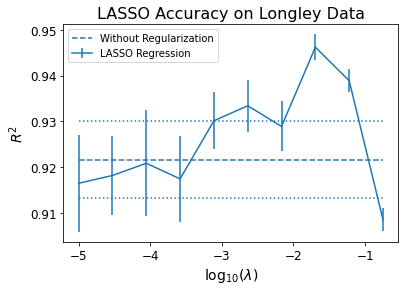

In [11]:
ax = plt.figure(figsize = (6, 4)).add_subplot()
ax.errorbar(np.log10(results[1:][:, 0]), results[1:][:, 1], 
            results[1:][:, 2],
            label = 'LASSO Regression')
ax.hlines(results[0,1], np.log10(results[1, 0]), 
           np.log10(results[-1, 0]), linestyles = 'dashed',
          label = 'Without Regularization')
ax.hlines(results[0,1]+results[0,2], np.log10(results[1, 0]), 
           np.log10(results[-1, 0]), linestyles = 'dotted')
ax.hlines(results[0,1]-results[0,2], np.log10(results[1, 0]), 
           np.log10(results[-1, 0]), linestyles = 'dotted')
ax.tick_params(labelsize=12)
ax.set_ylabel('$R^2$', fontsize = 14)
#ax.set_xlim([-4, -1])
plt.legend(loc = 'best')
ax.set_xlabel('$\log_{10}(\lambda)$', fontsize = 14)
ax.set_title('LASSO Accuracy on Longley Data', fontsize = 16);

In [12]:
df = pd.DataFrame(mean_params, columns = ['$\log_{10}(\lambda)$', 'GNPDEFL', 'GNP', 'UNEMP', 'ARMED', 'POP', 'const'])
param_df = df[['GNPDEFL', 'GNP', 'UNEMP', 'ARMED', 'POP', 'const']].iloc[1:].copy()
param_df.index = np.log10(df.iloc[1:]['$\log_{10}(\lambda)$'])

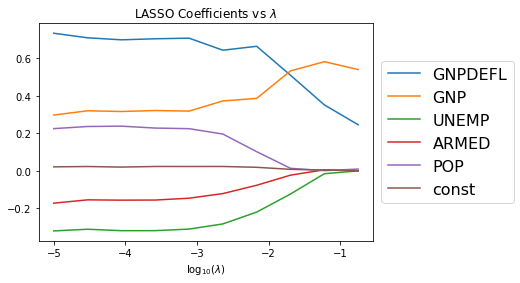

In [13]:
param_df.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 16})
plt.title('LASSO Coefficients vs $\lambda$');

## Flexible Modeling

To look at model selection in practice, we will consider another famous dataset.

The Guerry dataset is a collection of historical data used in support of Andre-Michel Guerry’s 1833 "Essay on the Moral Statistics of France."

>Andre-Michel Guerry’s (1833) Essai sur la Statistique Morale
de la France was one of the foundation studies of modern social science.
Guerry assembled data on crimes, suicides, literacy and other “moral
statistics,” and used tables and maps to analyze a variety of social issues
in perhaps the first comprehensive study relating such variables.

Wikipedia

>Guerry’s results were startling for two reasons.
First he showed that rates of crime and suicide remained
remarkably stable over time, when broken
down by age, sex, region of France and even season
of the year; yet these numbers varied systematically
across departements of France. This regularity
of social numbers created the possibility to
conceive, for the first time, that human actions in
the social world were governed by social laws, just
as inanimate objects were governed by laws of the
physical world.

Source: "A.-M. Guerry’s Moral Statistics of France: Challenges for Multivariable
Spatial Analysis", Michael Friendly.  Statistical Science 2007, Vol. 22, No. 3, 368–399.

In [14]:
X['TOTEMP'] = y

In [15]:
mod = smf.ols(formula='TOTEMP ~ GNPDEFL + GNP + UNEMP + ARMED + POP', data=X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     156.4
Date:                Wed, 03 Nov 2021   Prob (F-statistic):           3.70e-09
Time:                        11:33:38   Log-Likelihood:                -117.83
No. Observations:                  16   AIC:                             247.7
Df Residuals:                      10   BIC:                             252.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.246e+04   3.52e+04      2.629      0.0

/Users/crovella/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


In [16]:
mod = smf.ols(formula='TOTEMP ~ GNPDEFL + GNP + UNEMP - 1', data=X)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                 TOTEMP   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.127e+04
Date:                Wed, 03 Nov 2021   Prob (F-statistic):                    1.92e-22
Time:                        11:33:38   Log-Likelihood:                         -137.20
No. Observations:                  16   AIC:                                      280.4
Df Residuals:                      13   BIC:                                      282.7
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/crovella/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


In [18]:
# Lottery is per-capital wager on Royal Lottery
df = sm.datasets.get_rdataset("Guerry", "HistData").data
df = df[['Lottery', 'Literacy', 'Wealth', 'Region']].dropna()
df.head()

,Lottery,Literacy,Wealth,Region
0,41,37,73,E
1,38,51,22,N
2,66,13,61,C
3,80,46,76,E
4,79,69,83,E


We can use another version of the module that can directly type formulas and expressions in the functions of the models.


We can specify the name of the columns to be used to predict another column, remove columns, etc.

In [19]:
mod = smf.ols(formula='Lottery ~ Literacy + Wealth + Region', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Wed, 03 Nov 2021   Prob (F-statistic):           1.07e-05
Time:                        11:36:03   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      38.6517      9.456      4.087      

__Categorical variables__

Patsy is the name of the interpreter that parses the formulas.

Looking at the summary printed above, notice that patsy determined that elements of Region were text strings, so it treated Region as a categorical variable. 

Patsy‘s default is also to include an intercept, so we automatically dropped one of the Region categories.

__Removing variables__

The “-” sign can be used to remove columns/variables. For instance, we can remove the intercept from a model by:

In [20]:
res = smf.ols(formula='Lottery ~ Literacy + Wealth + C(Region) -1 ', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Wed, 03 Nov 2021   Prob (F-statistic):           1.07e-05
Time:                        11:36:03   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(Region)[C]    38.6517      9.456      4.087   

__Functions__

We can also apply vectorized functions to the variables in our model:

In [21]:
res = smf.ols(formula='Lottery ~ np.log(Literacy)', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     15.89
Date:                Wed, 03 Nov 2021   Prob (F-statistic):           0.000144
Time:                        11:36:03   Log-Likelihood:                -385.38
No. Observations:                  85   AIC:                             774.8
Df Residuals:                      83   BIC:                             779.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          115.6091     18.374  